# Time Series Analysis and Forecasting with Python

This notebook demonstrates various time series analysis and forecasting techniques using Python libraries such as pandas, numpy, matplotlib, statsmodels, and tensorflow.

## Importing Required Libraries

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tools.eval_measures import aic, bic
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings


warnings.filterwarnings("ignore")


# Load the dataset

In [75]:
data = pd.read_csv("AirPassengers.csv") 

In [76]:
print(data.head())

     Timeline     Month  Year  Number_of_Passengers  Unnamed: 4
0  01-01-1949   January  1949                 112.0         NaN
1  01-02-1949  February  1949                 118.0         NaN
2  01-03-1949     March  1949                 132.0         NaN
3  01-04-1949     April  1949                 129.0         NaN
4  01-05-1949       May  1949                 121.0         NaN


# EDA

In [77]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timeline              144 non-null    object 
 1   Month                 144 non-null    object 
 2   Year                  144 non-null    int64  
 3   Number_of_Passengers  144 non-null    float64
 4   Unnamed: 4            0 non-null      float64
dtypes: float64(2), int64(1), object(2)
memory usage: 5.8+ KB
None


In [78]:
data['Timeline'] = pd.to_datetime(data['Timeline'], format='%d-%m-%Y')

In [79]:
data.set_index('Timeline', inplace=True)


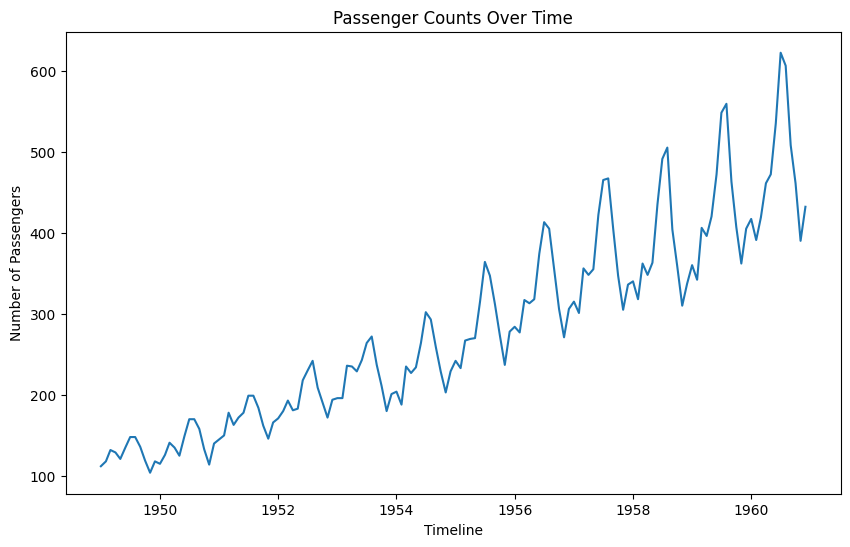

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Number_of_Passengers'])  # Plotting date vs passenger counts
plt.title('Passenger Counts Over Time')
plt.xlabel('Timeline')
plt.ylabel('Number of Passengers')
plt.show()


# Check for stationarity

In [81]:
def test_stationarity(timeseries):
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(data['Number_of_Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


# Decompose the time series

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['Number_of_Passengers'], model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


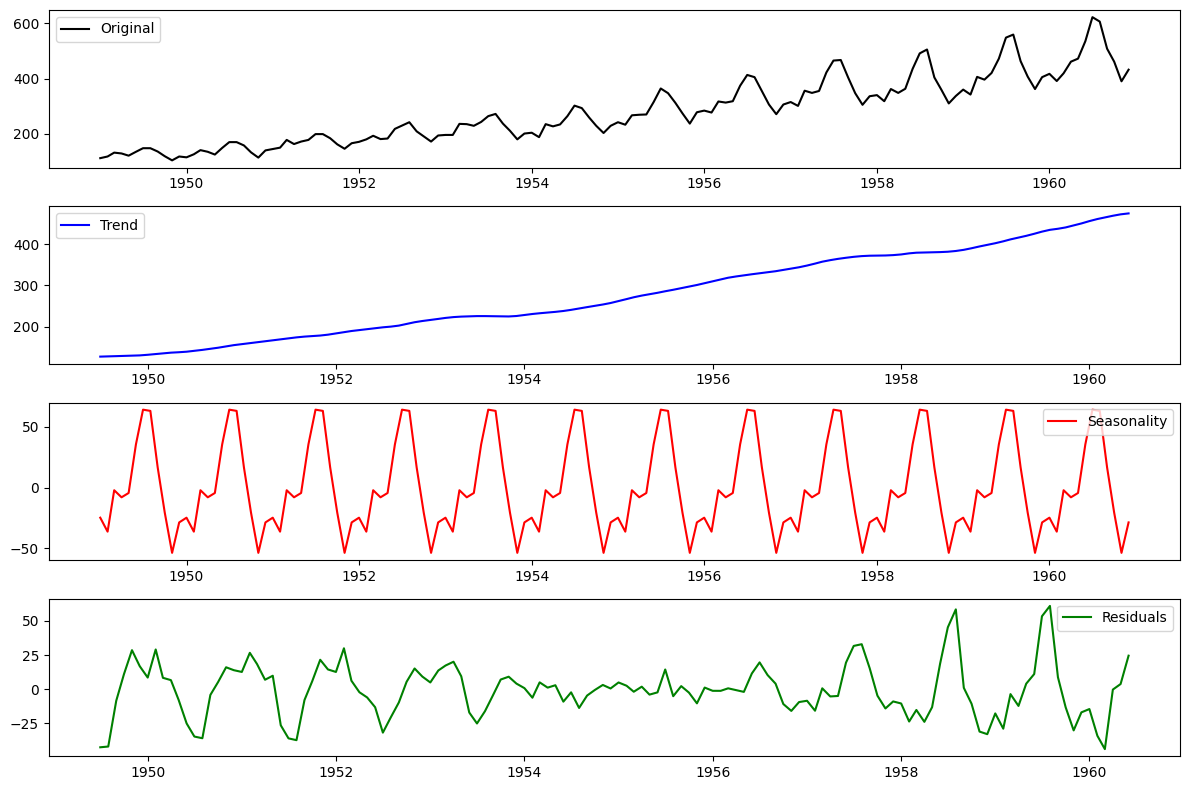

In [83]:
plt.figure(figsize=(12, 8))
# Plot original data
plt.subplot(411)
plt.plot(data.index, data['Number_of_Passengers'], label='Original', color='black')
plt.legend(loc='best')

# Plot trend
plt.subplot(412)
plt.plot(data.index, trend, label='Trend', color='blue')
plt.legend(loc='best')

# Plot seasonal component
plt.subplot(413)
plt.plot(data.index, seasonal, label='Seasonality', color='red')
plt.legend(loc='best')

# Plot residuals
plt.subplot(414)
plt.plot(data.index, residual, label='Residuals', color='green')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# ACF and PACF plots

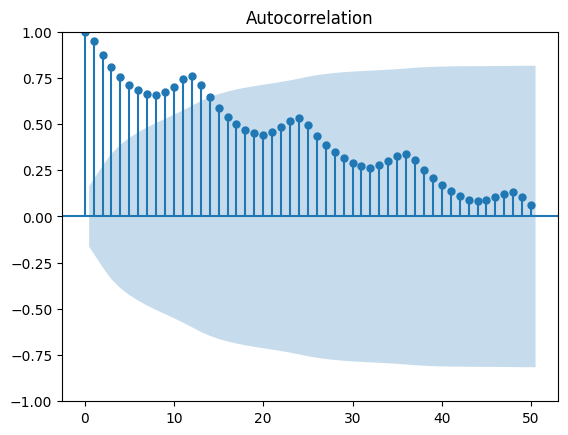

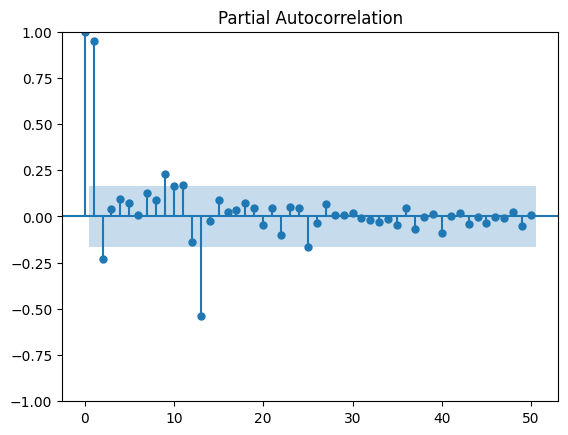

In [84]:

plot_acf(data['Number_of_Passengers'], lags=50)
plt.show()

plot_pacf(data['Number_of_Passengers'], lags=50)
plt.show()


# Fit ARIMA model

In [113]:
from statsmodels.tools.eval_measures import aic, bic
arima_model = ARIMA(data['Number_of_Passengers'], order=(5, 1, 0))
arima_results = arima_model.fit()


In [117]:
# Calculate AIC and BIC
aic_value = aic(arima_results.llf, arima_results.nobs, arima_results.df_model)
bic_value = bic(arima_results.llf, arima_results.nobs, arima_results.df_model)

# Print AIC and BIC
print('AIC:', aic_value)
print('BIC:', bic_value)

AIC: 1390.134632147816
BIC: 1407.953511945272


In [120]:
# Forecast
forecast = arima_results.forecast(steps=12)

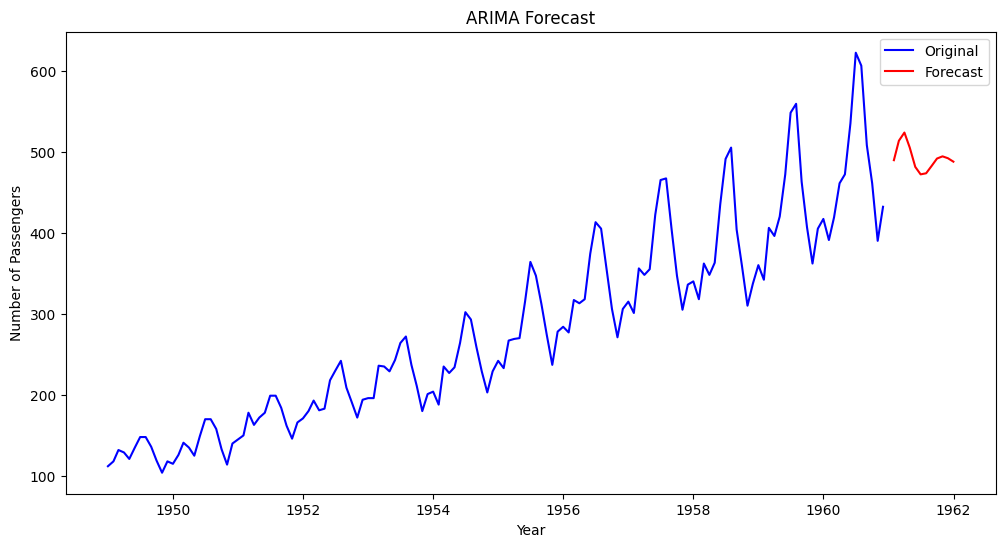

In [121]:
# Plot original data and ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Number_of_Passengers'], label='Original', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=13, freq='M')[1:], forecast, color='red', label='Forecast')
plt.title('ARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# LSTM model

In [122]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(np.array(data['Number_of_Passengers']).reshape(-1,1))

train_size = int(len(data_scaled) * 0.7)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)


In [89]:
time_step = 10
X_train, Y_train = create_dataset(train, time_step)
X_test, Y_test = create_dataset(test, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [90]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50, return_sequences=True))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
2/2 [==============================] - 8s 2s/step - loss: 0.0676 - val_loss: 0.3133
Epoch 2/100
2/2 [==============================] - 0s 78ms/step - loss: 0.0467 - val_loss: 0.2217
Epoch 3/100
2/2 [==============================] - 0s 63ms/step - loss: 0.0273 - val_loss: 0.1291
Epoch 4/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0120 - val_loss: 0.0514
Epoch 5/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0110 - val_loss: 0.0270
Epoch 6/100
2/2 [==============================] - 0s 63ms/step - loss: 0.0178 - val_loss: 0.0294
Epoch 7/100
2/2 [==============================] - 0s 78ms/step - loss: 0.0143 - val_loss: 0.0450
Epoch 8/100
2/2 [==============================] - 0s 60ms/step - loss: 0.0093 - val_loss: 0.0683
Epoch 9/100
2/2 [==============================] - 0s 63ms/step - loss: 0.0086 - val_loss: 0.0870
Epoch 10/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0097 - val_loss: 0.0940
Epoch 11/100
2/2 [===

# Prediction

In [91]:
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)

2/2 [==============================] - 0s 0s/step


In [92]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [98]:
# Check the lengths of data['Number_of_Passengers'] and test_predict
print("Length of Number_of_Passengers:", len(data['Number_of_Passengers']))
print("Length of test_predict:", len(test_predict))


Length of Number_of_Passengers: 144
Length of test_predict: 33


# AIC and BIC for LSTM

AIC LSTM: Timeline
1958-04-01    -692.0
1958-05-01    -722.0
1958-06-01    -866.0
1958-07-01    -978.0
1958-08-01   -1006.0
1958-09-01    -804.0
1958-10-01    -714.0
1958-11-01    -616.0
1958-12-01    -670.0
1959-01-01    -716.0
1959-02-01    -680.0
1959-03-01    -808.0
1959-04-01    -788.0
1959-05-01    -836.0
1959-06-01    -940.0
1959-07-01   -1092.0
1959-08-01   -1114.0
1959-09-01    -922.0
1959-10-01    -810.0
1959-11-01    -720.0
1959-12-01    -806.0
1960-01-01    -830.0
1960-02-01    -778.0
1960-03-01    -834.0
1960-04-01    -918.0
1960-05-01    -940.0
1960-06-01   -1066.0
1960-07-01   -1240.0
1960-08-01   -1208.0
1960-09-01   -1012.0
1960-10-01    -918.0
1960-11-01    -776.0
1960-12-01    -860.0
Name: Number_of_Passengers, dtype: float64
BIC LSTM: Timeline
1958-04-01    -684.114569
1958-05-01    -714.113007
1958-06-01    -858.149305
1958-07-01    -970.213553
1958-08-01    -998.280720
1958-09-01    -796.300691
1958-10-01    -706.269597
1958-11-01    -608.206100
1958-12-01    -662

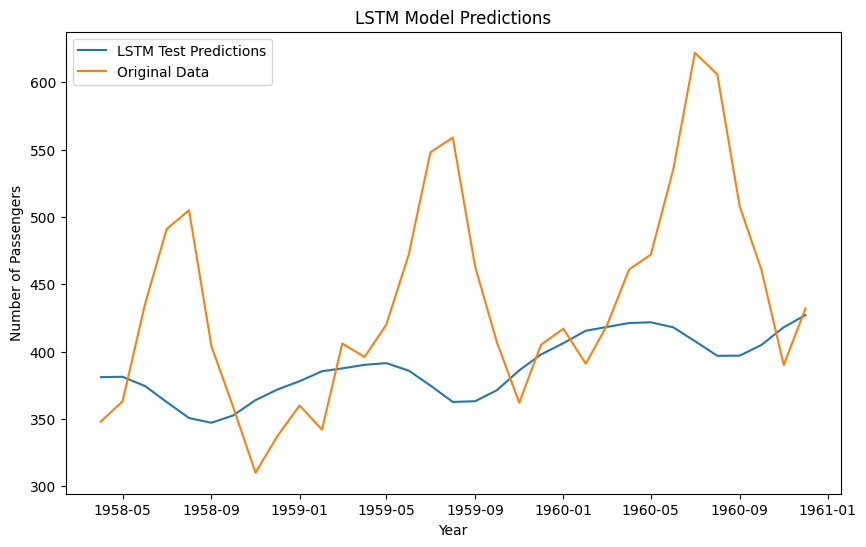

In [100]:
AIC_lstm = aic(data['Number_of_Passengers'].tail(len(test_predict)), test_predict[:, 0], 2)
BIC_lstm = bic(data['Number_of_Passengers'].tail(len(test_predict)), test_predict[:, 0], 2)
print("AIC LSTM:", AIC_lstm)
print("BIC LSTM:", BIC_lstm)

# Plot LSTM predictions
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(test_predict):], test_predict[:, 0], label='LSTM Test Predictions')
plt.plot(data.index[-len(test_predict):], data['Number_of_Passengers'].tail(len(test_predict)), label='Original Data')
plt.title('LSTM Model Predictions')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


# Exponential smoothing model

In [123]:
model_exp = ExponentialSmoothing(data['Number_of_Passengers'], trend='additive', seasonal='additive', seasonal_periods=12)
results_exp = model_exp.fit()


In [124]:
# Print summary, AIC, and BIC
print(results_exp.summary())
print('AIC:', results_exp.aic)
print('BIC:', results_exp.bic)

                       ExponentialSmoothing Model Results                       
Dep. Variable:     Number_of_Passengers   No. Observations:                  144
Model:             ExponentialSmoothing   SSE                          21564.431
Optimized:                         True   AIC                            753.294
Trend:                         Additive   BIC                            800.811
Seasonal:                      Additive   AICC                           758.766
Seasonal Periods:                    12   Date:                 Sun, 05 May 2024
Box-Cox:                          False   Time:                         18:25:30
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2525499                alpha                 True
smoothing_trend          

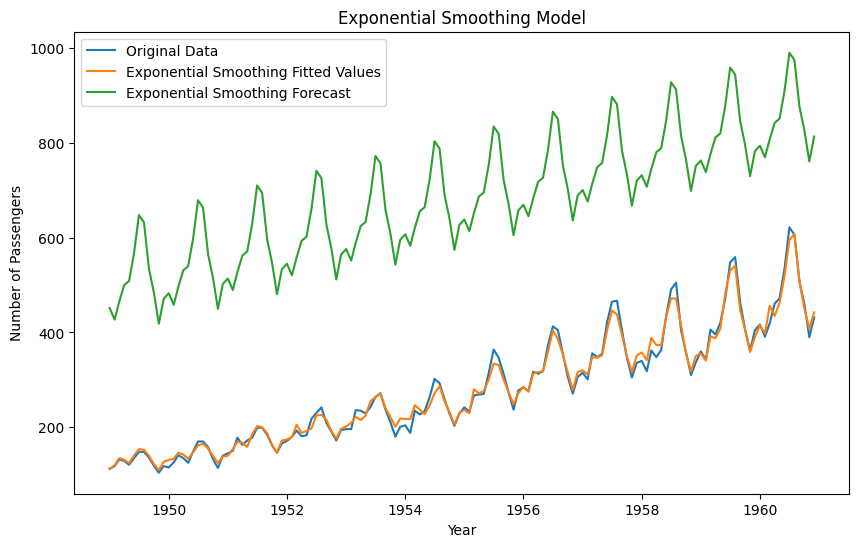

In [125]:
# Plot the original data and the exponential smoothing predictions
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Number_of_Passengers'], label='Original Data')
plt.plot(data.index, results_exp.fittedvalues, label='Exponential Smoothing Fitted Values')
plt.plot(data.index, results_exp.forecast(len(data)), label='Exponential Smoothing Forecast')
plt.title('Exponential Smoothing Model')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()
